# Movie Recommendation Submission

* Student name: Kregg Jackson 
* Student pace: self paced
* Instructor name: Abhineet Kulkarni
* Blog post URL: https://medium.com/@kr3ggjac.cj/data-science-effect-on-professional-sports-b11d3dc3e350

### Stakeholder

This project was built for a website designed to make personalized movie recommendations to the user based off their ratings of movies.

### Business Problem

The recommendation system is designed to predict user preference and expose the user to movies that they will like. When done correctly the system will support and improve the quality of the decisions users make while searching for movies. 

### Data
The data set is a dictionary of two dataframes one with movie data and the other with ratings data. The movies dataframe has 9,700 rows of three columns with `movieId`, `title`, and `genre` data. The ratings column originally had over 100,000 rows of reviews with four columns of `userId`, `movieId`, `rating`, and `timestamp`. 

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import surprise
from surprise import Dataset, Reader
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly 
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import knns
from surprise.model_selection import GridSearchCV
import os
print(os.listdir("/Users/kregg/Flatiron/dsc-phase-4-project/data/ml-latest-small"))

['links.csv', 'tags.csv', 'ratings.csv', 'README.txt', 'movies.csv']


In [2]:
ratings = pd.read_csv("/Users/kregg/Flatiron/dsc-phase-4-project/data/ml-latest-small/ratings.csv")
movies = pd.read_csv("/Users/kregg/Flatiron/dsc-phase-4-project/data/ml-latest-small/movies.csv")

## EDA

In [3]:
print(movies.info())
movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
print(ratings.info())
ratings['rating'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [6]:
ratings['userId'].value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

In [7]:
ratings['movieId'].sort_values() 

0             1
81531         1
30517         1
81082         1
30601         1
          ...  
27256    193581
27257    193583
27258    193585
27259    193587
51362    193609
Name: movieId, Length: 100836, dtype: int64

In [8]:
movie_ratings = pd.merge(movies, ratings)
movie_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


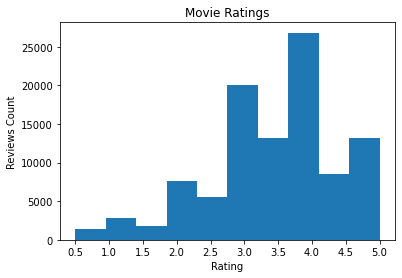

In [10]:
plt.hist(ratings['rating'])
plt.xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.title('Movie Ratings')
plt.ylabel('Reviews Count')
plt.xlabel('Rating')
plt.show()

The bell curve is skewed to the left, and the most common rating is a 4. It is more common that a user gives a movie a positive rating (higher than 2.5). This skew is likely either due to users reviewing more movies they enjoyed compared to ones they did not or some kind of rater bias.

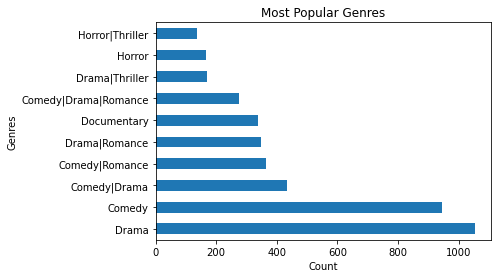

In [11]:
movies['genres'].value_counts().nlargest(10).plot(kind = 'barh')
plt.title('Most Popular Genres')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.show()

The two most popular geres by a lot are `Drama` and `Comedy`, and the third most popular is `Comedy|Drama`. Seven of the ten most popular genres are some variation of Drama or Comedy. These are likely the most common genres and the most enjoyed among users.

In [12]:
ratings = ratings.drop(columns='timestamp')

### Recommendation systems

In [13]:
reader = surprise.Reader(rating_scale=(.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
type(data)

surprise.dataset.DatasetAutoFolds

In [14]:
dataset = data.build_full_trainset()
print('Number of users:', dataset.n_users)
print('Number of items:', dataset.n_items)

Number of users: 610
Number of items: 9724


In [15]:
cv = []
# Iterate over the algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(),
                  NormalPredictor(), KNNBaseline(), KNNBasic(), 
                  KNNWithMeans(), KNNWithZScore(), BaselineOnly()]:
# Cross validation
    tmp = cross_validate(algorithm, data, measures=['RMSE'], 
                         cv=3, verbose=False)
    cv.append((str(algorithm).split(' ')[0].split('.')[-1], 
               tmp['test_rmse'].mean()))

performance_df = pd.DataFrame(cv, columns=['Algorithm', 'RMSE'])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [16]:
# Results
performance_df.sort_values(by=['RMSE'], ascending = True).set_index('Algorithm')

,RMSE
Algorithm,
SVDpp,0.869443
BaselineOnly,0.877270
SVD,0.880737
KNNBaseline,0.882685
KNNWithZScore,0.905225
KNNWithMeans,0.905818
SlopeOne,0.911303
NMF,0.937928
KNNBasic,0.960428


SVDpp, BaselineOnly, and SVD are the three highest performing so I'll run a gridsearch to find the best parameters and get the most accurate recommendations from the best performing model.

### Gridsearch

In [17]:
# Train-test split
train, test = train_test_split(data, test_size = 0.2)

In [18]:
train

In [19]:
# SVD gridsearch
param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10], 
              'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}
grid_search = GridSearchCV(SVD, param_grid = param_grid,n_jobs = -1,
                           joblib_verbose = 5)
grid_search.fit(data)
print(grid_search.best_params)
print(grid_search.best_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.0s


{'rmse': {'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}, 'mae': {'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}}
{'rmse': 0.8905440050335527, 'mae': 0.6895856647473094}


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   23.4s finished


In [22]:
svd_grid = SVD(n_factors= 20, n_epochs= 10, lr_all= 0.005, reg_all= 0.4)
svd_grid.fit(train)
predictions = svd_grid.test(test)

In [23]:
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.8885
MAE:  0.6890


0.6889604422941044

After running gridsearch to the moat optimal parameters the RMSE score went up from 0.88 to 0.89. This is likely due to the parameters overfitting the SVD recommendation system. I will make the predictions wth the stock parameters because they return more accurate recommendations.

In [24]:
# BaselineOnly gridsearch
baseline = {'method': 'als', 'random_state':250, 'n_epochs': 5,
            'reg_u': 12, 'reg_i': 5}
algo_grid = BaselineOnly(baseline)
cross_validate(algo_grid, data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.87086851, 0.87523073, 0.86743298]),
 'fit_time': (0.06056499481201172, 0.06495523452758789, 0.08293294906616211),
 'test_time': (0.19075584411621094, 0.08258700370788574, 0.15265798568725586)}

In [26]:
algo_grid = BaselineOnly(baseline)
predictions = algo_grid.fit(train).test(test)
accuracy.rmse(predictions)
accuracy.mae(predictions)

Estimating biases using als...
RMSE: 0.8651
MAE:  0.6670


0.6669846746280212

The BaselineOnly recommendation system's RMSE is 0.8 points lower than the original making it the most accurate recommendation system.

In [30]:
#SVD++ gridsearch
svdpp_grid = SVDpp(n_factors= 20, n_epochs= 20, lr_all= 0.005, 
              reg_all= 0.02)
svdpp_grid.fit(train)
predictions = svdpp_grid.test(test)

In [31]:
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.8601
MAE:  0.6610


0.6609733999385077

In [33]:
cv_svdpp = cross_validate(svdpp_grid, data)
np.mean(cv_svdpp['test_rmse'])

0.8610113912742545

In [34]:
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.8601
MAE:  0.6610


0.6609733999385077

### Recommendation predictions

In [36]:
svdpp_grid.fit(data.build_full_trainset())

In [37]:
unique_ids = ratings['movieId'].unique()

user274_ratings = ratings.loc[ratings['userId'] == 274, 'movieId']

movies_to_predict = np.setdiff1d(unique_ids, user274_ratings)

In [38]:
my_recs = []
# SVD++ movie recommendations
for model in movies_to_predict:
    my_recs.append((model, svdpp_grid.predict(uid = 274, iid = model).est))
svdpp_recs = pd.DataFrame(my_recs, columns=['movieId', 
            'predictions']).sort_values('predictions', 
            ascending=False)
svdpp_recs.head(9)

,movieId,predictions
2897,4973,4.166659
5448,57669,4.107143
8254,177593,4.104377
2028,3451,4.086689
4945,38061,4.083549
7012,109487,4.070470
524,898,4.048249
157,246,4.046203
455,720,4.031041


In [39]:
title_recs = movie_ratings.iloc[svdpp_recs.index, 1]
svdpp_rectitles = pd.DataFrame(title_recs, columns = ['title'])
svdpp_rectitles.head(6)

,title
2897,From Dusk Till Dawn (1996)
5448,"Prophecy, The (1995)"
8254,"Queen Margot (Reine Margot, La) (1994)"
2028,Mortal Kombat (1995)
4945,Die Hard: With a Vengeance (1995)
7012,Star Wars: Episode IV - A New Hope (1977)


In [43]:
svd = SVD()
svd.fit(data.build_full_trainset())
my_recs = []
# SVD movie recommendations
for model in movies_to_predict:
    my_recs.append((model, svd.predict(uid = 274, iid = model).est))
    
svd_recs = pd.DataFrame(my_recs, columns=['movieId', 
                               'predictions']).sort_values('predictions', 
                                ascending=False)
svd_recs.head()

,movieId,predictions
2897,4973,4.213283
710,1204,4.104844
3882,7099,4.062651
7102,112552,4.057987
719,1225,4.025152


In [44]:
title_recs = movie_ratings.iloc[svd_recs.index, 1]
svd_rectitles = pd.DataFrame(title_recs, columns = ['title'])
svd_rectitles.head()

,title
2897,From Dusk Till Dawn (1996)
710,GoldenEye (1995)
3882,Up Close and Personal (1996)
7102,Star Wars: Episode IV - A New Hope (1977)
719,GoldenEye (1995)


In [45]:
algo = BaselineOnly(baseline)
algo_grid.fit(data.build_full_trainset())
my_recs = []
# BaselineOnly movie recommendtions
for model in movies_to_predict:
    my_recs.append((model, algo_grid.predict(uid = 274, iid = model).est))
    
baseline_recs = pd.DataFrame(my_recs, columns=['movieId',
                               'predictions']).sort_values('predictions',
                                ascending=False)
baseline_recs.head()

Estimating biases using als...


,movieId,predictions
710,1204,4.134364
8254,177593,4.096904
656,1104,4.095960
2028,3451,4.069627
524,898,4.045495


In [46]:
title_recs = movie_ratings.iloc[baseline_recs.index, 1]
baseline_rectitles = pd.DataFrame(title_recs, columns = ['title'])
baseline_rectitles.head()

,title
710,GoldenEye (1995)
8254,"Queen Margot (Reine Margot, La) (1994)"
656,GoldenEye (1995)
2028,Mortal Kombat (1995)
524,Heat (1995)


In [47]:
cv = [] 
# Iterate over the algorithms
for recsys in [SVD(), SVDpp(), BaselineOnly()]:
# Cross validation   
    tmp = cross_validate(recsys, data, measures=['RMSE'], cv=3, verbose=False)
    cv.append((str(recsys).split(' ')[0].split('.')[-1], tmp['test_rmse'].mean()))
results = pd.DataFrame(cv, columns=['RecSys', 'RMSE'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [48]:
results.head().sort_values('RMSE', ascending = True)

,RecSys,RMSE
1,SVDpp,0.867798
2,BaselineOnly,0.876949
0,SVD,0.879991


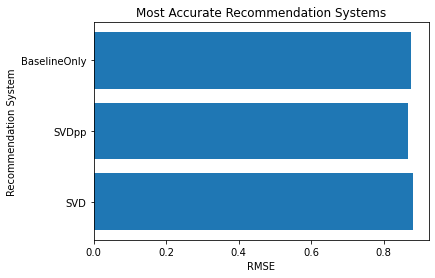

In [49]:
plt.subplot(111).barh(results['RecSys'], results['RMSE'])
plt.title('Most Accurate Recommendation Systems')
plt.xlabel('RMSE')
plt.ylabel('Recommendation System')
plt.show()

* The SVD system was able to predict rating within 0.88 points on average

* The BaselineOnly recommendation system predicted rating within 0.87 points

* The best performing system was the SVD ++, and was able to predict user ratings within 0.86 points on average

## Conclusion

* The best performing recommendation system is the SVD ++ system with a RMSE of 0.86.

* Multiple recommendation syatems are tuned and able to predict user preference within 0.9 points of the actual rating on average.

* The movie suggestion website will be able to take users previous rating and recommend movies the user has not seen.


### Next Steps

* Have recommendation system not only suggest singular movies but movie genres.

* Running gridsearch on SVD++ was very taxing on my machine’s CPU with more time I could test more parameters to see if I could lower the RMSE of the mos accurate system.

* Build a function to accept new user data.

## Thank You